# Load Landslide4Sense Metadata

This cell loads and displays the Croissant metadata JSON file for the Landslide4Sense dataset. The JSON contains important information about the dataset structure, file paths, and data specifications.

In [2]:
import json

# Load and pretty-print the content of croissant.json
with open("Landslide4sense.json", "r") as f:
    croissant_data = json.load(f)

# Pretty-print JSON to console
print(json.dumps(croissant_data, indent=2))

{
  "@context": {
    "@language": "en",
    "@vocab": "https://schema.org/",
    "citeAs": "cr:citeAs",
    "column": "cr:column",
    "conformsTo": "dct:conformsTo",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/croissant/geocr/",
    "rai": "http://mlcommons.org/croissant/RAI/",
    "dct": "http://purl.org/dc/terms/",
    "sc": "https://schema.org/",
    "data": {
      "@id": "cr:data",
      "@type": "@json"
    },
    "examples": {
      "@id": "cr:examples",
      "@type": "@json"
    },
    "dataBiases": "cr:dataBiases",
    "dataCollection": "cr:dataCollection",
    "dataType": {
      "@id": "cr:dataType",
      "@type": "@vocab"
    },
    "extract": "cr:extract",
    "field": "cr:field",
    "fileProperty": "cr:fileProperty",
    "fileObject": "cr:fileObject",
    "fileSet": "cr:fileSet",
    "format": "cr:format",
    "includes": "cr:includes",
    "isLiveDataset": "cr:isLiveDataset",
    "jsonPath": "cr:jsonPath",
    "key": "cr:key",
   

# Validate Croissant Metadata Format

Uses the mlcroissant tool to validate the JSON-LD metadata file against the Croissant schema standards. This ensures the metadata is properly formatted and contains all required fields.

In [1]:
!mlcroissant validate --jsonld=Landslide4sense.json

I0902 10:34:57.883636 132298673127808 validate.py:53] Done.


# Load and Visualize HDF5 Images Using Metadata

This cell demonstrates how to:
- Load the Croissant metadata JSON file
- Extract image paths and data specifications from metadata
- Open HDF5 image files using h5py
- Handle different data formats (HDF5 vs TIFF masks)
- Visualize RGB composite and mask data side by side
- Properly transpose array dimensions for visualization

The code handles the common HDF5 format where data is stored as (bands, height, width) and converts it to (height, width, bands) for visualization.

Image path from metadata: /teamspace/studios/this_studio/Landslide4Sense/images/train/image_100.h5
Mask path from metadata: /teamspace/studios/this_studio/Landslide4Sense/annotations/train/mask_100.h5
Top-level keys in HDF5: ['img']
Original HDF5 shape: (128, 128, 14)
Image shape for visualization (H, W, bands): (128, 128, 14)
Mask shape: (128, 128)


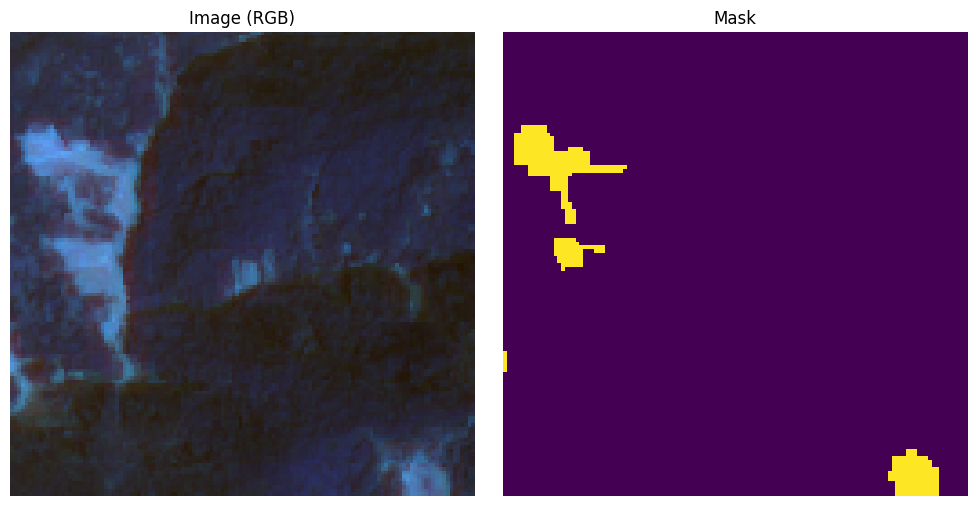

In [3]:
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from osgeo import gdal

# 1. Load metadata
metadata_path = "/teamspace/studios/this_studio/Landslide4sense.json"
with open(metadata_path, "r") as f:
    metadata = json.load(f)

# 2. Get paths from metadata
repo_path = Path(metadata["distribution"][0]["path"])
split = "train"

# First image and mask from metadata
image_path = repo_path / metadata["geocr:fileListing"]["images"][split][2]
mask_path = repo_path / metadata["geocr:fileListing"]["annotations"][split][2]

print("Image path from metadata:", image_path)
print("Mask path from metadata:", mask_path)

# 3. Open image using h5py
with h5py.File(image_path, "r") as f:
    print("Top-level keys in HDF5:", list(f.keys()))
    data = f["img"][:]  # 'img' is the dataset name
    print("Original HDF5 shape:", data.shape)

# 4. Check shape and transpose if needed
# Usually HDF5 gives (bands, H, W)
if data.shape[0] <= 20:  # heuristic for (bands, H, W)
    image = np.transpose(data, (1, 2, 0))  # (H, W, bands)
else:
    image = data  # already (H, W, bands)

print("Image shape for visualization (H, W, bands):", image.shape)

# 5. Open mask using GDAL
mask_ds = gdal.Open(str(mask_path))
mask = mask_ds.GetRasterBand(1).ReadAsArray()
print("Mask shape:", mask.shape)

# 6. Pick first 3 bands for RGB visualization
rgb_image = image[:, :, :3]

# 7. Normalize for display
rgb_image_norm = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# 8. Plot RGB image and mask side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(rgb_image_norm)
ax1.set_title("Image (RGB)")
ax1.axis("off")

ax2.imshow(mask, cmap="viridis")
ax2.set_title("Mask")
ax2.axis("off")

plt.tight_layout()
plt.show()

# Import Prithvi Model Fine-tuning Components

Imports the custom fine-tuning module containing:
- MultispectralTransforms: Data augmentation for satellite imagery
- LandslideDataset: Custom dataset class for loading HDF5 images
- PrithviLandslideClassifier: Model architecture combining Prithvi encoder with classification head
- Training and evaluation utilities

Sets up the Python path to access the custom module.

In [4]:
# Add the current directory to Python path
import sys
import os

sys.path.append("/teamspace/studios/this_studio/prithvi_model")

# Now import
from finetune_landslide_complete import (
    MultispectralTransforms,
    LandslideDataset,
    PrithviLandslideClassifier,
    load_pretrained_prithvi,
    train_model,
    plot_training_curves,
    evaluate_model,
)


import torch
import torch.nn as nn
import wandb
from torch.utils.data import DataLoader

# Fine-tune Prithvi Model for Landslide Detection

This comprehensive cell performs the complete model training pipeline:

1. **Setup**: Configure device (GPU/CPU) and initialize Weights & Biases logging
2. **Data Pipeline**: Create datasets and data loaders for train/validation/test splits
3. **Model Architecture**: 
   - Load pre-trained Prithvi EO 100M model
   - Add classification head for binary landslide detection
   - Configure for 14-band multispectral input
4. **Training**: Execute 15 epochs with data augmentation and validation monitoring
5. **Outputs**: Save best model checkpoint based on F1 score

The model uses transfer learning from the pre-trained Prithvi foundation model, adapting it for landslide detection from 14-band satellite imagery.

Using device: cuda


wandb: Currently logged in as: harshinde (Silvamillion) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Creating datasets...
Found 3799 images and 3804 annotations for train split
Found 245 images and 245 annotations for validation split
Found 800 images and 800 annotations for test split
Train samples: 3799
Validation samples: 245
Test samples: 800

Initializing model...
Loading pre-trained Prithvi model from: /teamspace/studios/this_studio/prithvi_model/Prithvi_EO_V1_100M.pt
Pre-trained weights loaded successfully!
Model parameters: 86,762,754
Trainable parameters: 525,570

Starting training...


Epoch 1/15 [Val]: 100%|██████████| 16/16 [00:03<00:00,  4.95it/s]


Epoch 1/15:
  Train Loss: 0.6752, Train F1: 0.4422, Train Acc: 0.5883
  Val Loss: 0.6690, Val F1: 0.4543, Val Acc: 0.6000
  New best model saved with F1: 0.4543


Epoch 2/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.37it/s]


Epoch 2/15:
  Train Loss: 0.6569, Train F1: 0.5336, Train Acc: 0.6181
  Val Loss: 0.6400, Val F1: 0.5514, Val Acc: 0.6204
  New best model saved with F1: 0.5514


Epoch 3/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.33it/s]


Epoch 3/15:
  Train Loss: 0.6393, Train F1: 0.6171, Train Acc: 0.6499
  Val Loss: 0.6234, Val F1: 0.5749, Val Acc: 0.6245
  New best model saved with F1: 0.5749


Epoch 4/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.14it/s]


Epoch 4/15:
  Train Loss: 0.6329, Train F1: 0.6279, Train Acc: 0.6546
  Val Loss: 0.6237, Val F1: 0.6439, Val Acc: 0.6571
  New best model saved with F1: 0.6439


Epoch 5/15 [Val]: 100%|██████████| 16/16 [00:01<00:00,  9.91it/s]


Epoch 5/15:
  Train Loss: 0.6328, Train F1: 0.6241, Train Acc: 0.6489
  Val Loss: 0.6512, Val F1: 0.6324, Val Acc: 0.6327


Epoch 6/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.17it/s]


Epoch 6/15:
  Train Loss: 0.6279, Train F1: 0.6410, Train Acc: 0.6628
  Val Loss: 0.6141, Val F1: 0.6581, Val Acc: 0.6735
  New best model saved with F1: 0.6581


Epoch 7/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 11.55it/s]


Epoch 7/15:
  Train Loss: 0.6228, Train F1: 0.6449, Train Acc: 0.6654
  Val Loss: 0.6097, Val F1: 0.6546, Val Acc: 0.6694


Epoch 8/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


Epoch 8/15:
  Train Loss: 0.6175, Train F1: 0.6429, Train Acc: 0.6607
  Val Loss: 0.6233, Val F1: 0.6701, Val Acc: 0.6694
  New best model saved with F1: 0.6701


Epoch 9/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.50it/s]


Epoch 9/15:
  Train Loss: 0.6170, Train F1: 0.6538, Train Acc: 0.6707
  Val Loss: 0.6204, Val F1: 0.6747, Val Acc: 0.6776
  New best model saved with F1: 0.6747


Epoch 10/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 11.67it/s]


Epoch 10/15:
  Train Loss: 0.6193, Train F1: 0.6451, Train Acc: 0.6644
  Val Loss: 0.6349, Val F1: 0.6441, Val Acc: 0.6408


Epoch 11/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.99it/s]


Epoch 11/15:
  Train Loss: 0.6160, Train F1: 0.6512, Train Acc: 0.6689
  Val Loss: 0.6198, Val F1: 0.6836, Val Acc: 0.6857
  New best model saved with F1: 0.6836


Epoch 12/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 11.91it/s]


Epoch 12/15:
  Train Loss: 0.6118, Train F1: 0.6585, Train Acc: 0.6749
  Val Loss: 0.6173, Val F1: 0.6822, Val Acc: 0.6857


Epoch 13/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.28it/s]


Epoch 13/15:
  Train Loss: 0.6182, Train F1: 0.6578, Train Acc: 0.6749
  Val Loss: 0.6168, Val F1: 0.6776, Val Acc: 0.6816


Epoch 14/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 11.63it/s]


Epoch 14/15:
  Train Loss: 0.6132, Train F1: 0.6579, Train Acc: 0.6741
  Val Loss: 0.6177, Val F1: 0.6822, Val Acc: 0.6857


Epoch 15/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 12.33it/s]


Epoch 15/15:
  Train Loss: 0.6140, Train F1: 0.6565, Train Acc: 0.6744
  Val Loss: 0.6179, Val F1: 0.6829, Val Acc: 0.6857
Training curves saved to: training_curves.png


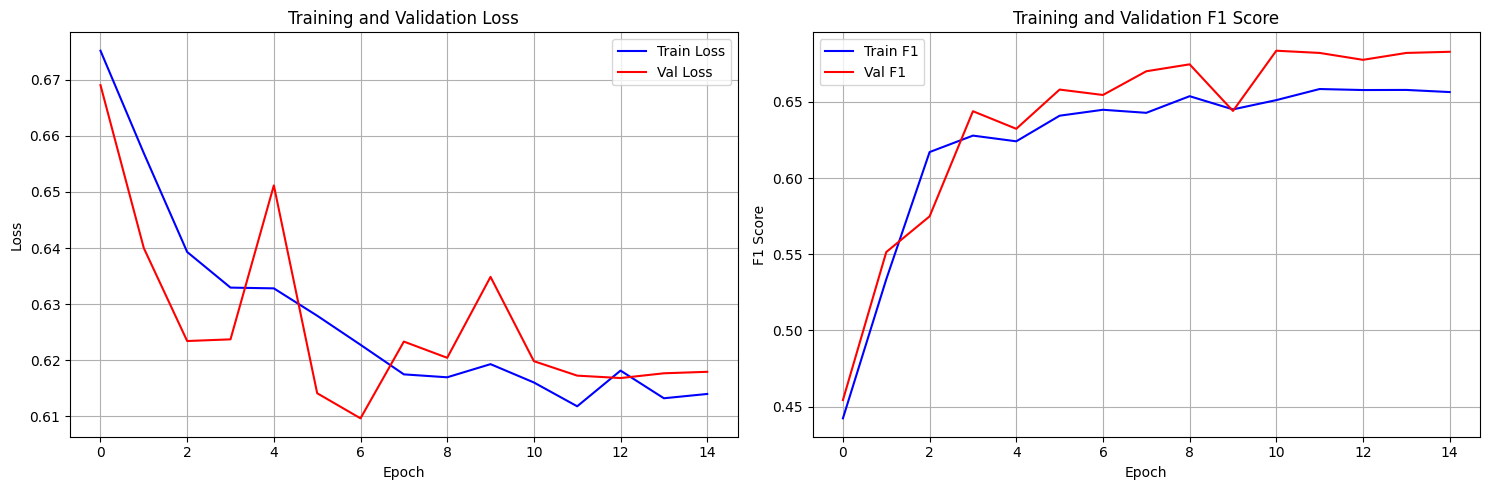

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize wandb
try:
    wandb.init(
        project="prithvi-landslide-finetuning",
        config={
            "model_type": "prithvi_eo_100m",
            "dataset": "landslide4sense",
            "num_bands": 14,
            "num_classes": 2,
            "img_size": 128,
            "batch_size": 16,
        },
        name="prithvi-eo-100m-landslide4sense",
    )
except:
    print("Wandb not available, continuing without logging")
    wandb.run = None


# Data transforms
def get_multispectral_transforms():
    """Get transforms for multispectral data"""

    def transform(img):
        # Apply custom multispectral transforms
        img = MultispectralTransforms.random_horizontal_flip(img, p=0.5)
        img = MultispectralTransforms.random_vertical_flip(img, p=0.5)
        img = MultispectralTransforms.random_rotation(img, max_angle=10)
        img = MultispectralTransforms.random_brightness_contrast(img)
        return img

    return transform


transform = get_multispectral_transforms()

# Create datasets
print("\nCreating datasets...")
metadata_path = "/teamspace/studios/this_studio/Landslide4sense.json"

train_dataset = LandslideDataset(metadata_path, split="train", transform=transform)
val_dataset = LandslideDataset(metadata_path, split="validation")
test_dataset = LandslideDataset(metadata_path, split="test")

# Create data loaders
batch_size = 16
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize model
print("\nInitializing model...")

# Load pre-trained Prithvi model using the downloaded weights
prithvi_config = {
    "img_size": 128,
    "patch_size": (1, 16, 16),  # (temporal, height, width)
    "num_frames": 1,  # Single frame for static images
    "in_chans": 6,  # Pre-trained model expects 6 bands
    "embed_dim": 768,
    "depth": 12,
    "num_heads": 12,
    "decoder_embed_dim": 512,
    "decoder_depth": 8,
    "decoder_num_heads": 16,
    "mlp_ratio": 4.0,
    "norm_layer": nn.LayerNorm,
    "norm_pix_loss": False,
    "coords_encoding": None,
    "coords_scale_learn": False,
    "encoder_only": True,  # Only use encoder for feature extraction
}

# Use the downloaded Prithvi model file with ABSOLUTE PATH
prithvi_checkpoint_path = (
    "/teamspace/studios/this_studio/prithvi_model/Prithvi_EO_V1_100M.pt"
)
prithvi_model = load_pretrained_prithvi(prithvi_checkpoint_path, prithvi_config)

# Create the classifier
model = PrithviLandslideClassifier(prithvi_model, num_classes=2)
model = model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    "Trainable parameters:"
    f" {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

# Train the model
print("\nStarting training...")
best_f1 = train_model(model, train_loader, val_loader, num_epochs=15, device=device)

# Locate Model Checkpoint Files

Searches for saved model files (.pt, .pth) in the project directory structure. This helps verify that the training process successfully saved model checkpoints and identifies their locations.

In [7]:
import os

# Check what files are in the prithvi_model directory
prithvi_dir = "/teamspace/studios/this_studio/prithvi_model"
print("Files in prithvi_model directory:")
for file in os.listdir(prithvi_dir):
    if file.endswith(".pth") or file.endswith(".pt"):
        print(f"  - {file}")

# Check current working directory
print(f"\nCurrent working directory: {os.getcwd()}")
print("Files in current directory:")
for file in os.listdir("."):
    if file.endswith(".pth") or file.endswith(".pt"):
        print(f"  - {file}")

Files in prithvi_model directory:
  - Prithvi_EO_V1_100M.pt

Current working directory: /teamspace/studios/this_studio
Files in current directory:
  - best_landslide_model.pth


# Verify Training Status and Checkpoint Existence

Checks if the training completed successfully by:
- Verifying training variables are accessible
- Confirming the best model checkpoint was saved
- Displaying training metrics if available

This diagnostic cell helps troubleshoot training issues and confirms model availability for inference.

In [9]:
# Check training status
print("Training Status Check:")
print("=" * 50)

# Check if training variables exist
try:
    print(f"best_f1 variable exists: {'best_f1' in locals()}")
    if "best_f1" in locals():
        print(f"best_f1 value: {best_f1}")
except:
    print("best_f1 variable not accessible")

# Check for checkpoint files
checkpoint_path = (
    "/teamspace/studios/this_studio/prithvi_model/best_landslide_model.pth"
)
print(f"Checkpoint exists: {os.path.exists(checkpoint_path)}")

Training Status Check:
best_f1 variable exists: True
best_f1 value: 0.683634053176507
Checkpoint exists: False


# Load Trained Model and Perform Landslide Detection

This cell demonstrates the complete inference pipeline:

1. **Model Loading**: 
   - Loads the trained model checkpoint
   - Recreates the Prithvi architecture
   - Restores trained weights

2. **Image Testing Function**:
   - Loads HDF5 images and preprocesses them
   - Handles array transposition and normalization
   - Performs model inference with confidence scoring

3. **Visualization**:
   - Displays RGB composite, NIR, and slope bands
   - Shows prediction results with confidence scores
   - Saves detailed results to JSON file

4. **Results Analysis**:
   - Binary classification (Landslide/No Landslide)
   - Confidence percentages for both classes
   - Confidence level assessment (High/Medium/Low)

The cell tests the model on `image_12.h5` and provides comprehensive visualization and analysis of the prediction results.

Using device: cuda
Loading model from checkpoint...


Loading pre-trained Prithvi model from: /teamspace/studios/this_studio/prithvi_model/Prithvi_EO_V1_100M.pt
Pre-trained weights loaded successfully!
Model loaded successfully!
   Best F1 score: 0.683634053176507
   Epoch: 10

TESTING LANDSLIDE DETECTION MODEL

Testing image: /teamspace/studios/this_studio/Landslide4Sense/images/test/image_12.h5
Original image shape: (128, 128, 14)
Tensor shape: torch.Size([14, 128, 128])
Final tensor shape: torch.Size([1, 14, 128, 128])

Prediction Results:
  Raw output: [[-0.25695723  0.51081383]]
  Prediction: LANDSLIDE
  Confidence: 0.6830
  Probabilities:
    - No Landslide: 0.3170
    - Landslide: 0.6830


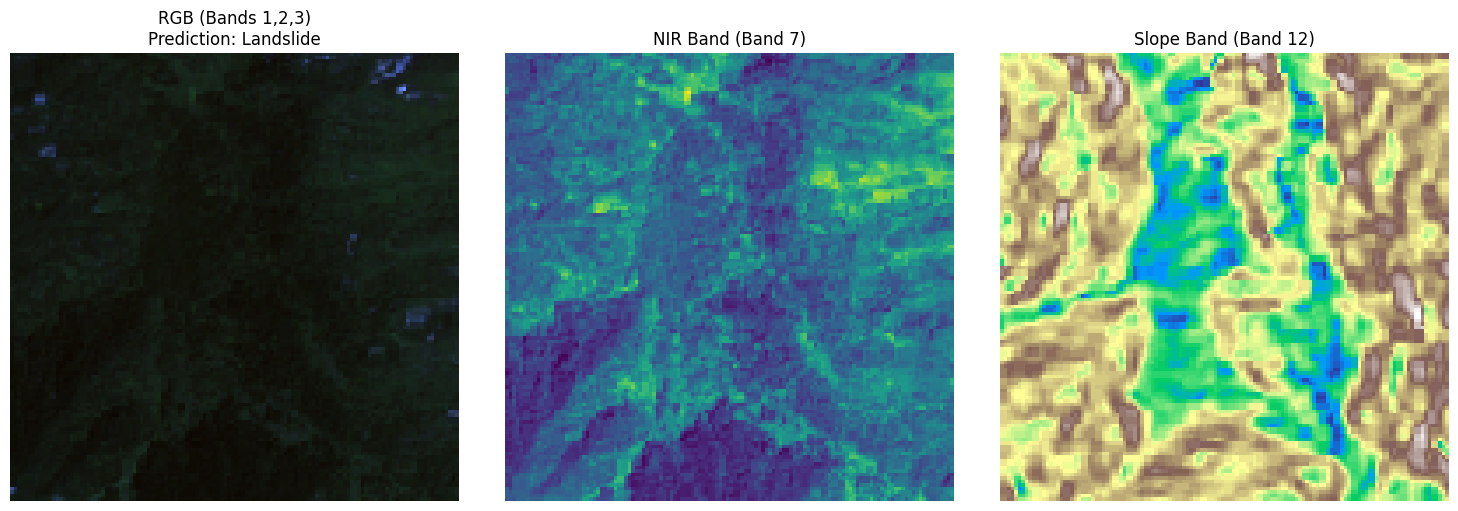


FINAL RESULT:
Image: image_12.h5
Prediction: LANDSLIDE DETECTED
Confidence: 68.30%
Result saved to: /teamspace/studios/this_studio/prithvi_model/image_12_test_result.json

Confidence Breakdown:
   No Landslide: 31.70%
   Landslide: 68.30%
   Medium confidence prediction


In [19]:
import torch
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model from checkpoint
checkpoint_path = "/teamspace/studios/this_studio/best_landslide_model.pth"

try:
    print("Loading model from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    # Load the model architecture first
    from finetune_landslide_complete import (
        PrithviLandslideClassifier,
        load_pretrained_prithvi,
    )

    # Recreate the Prithvi model
    prithvi_config = {
        "img_size": 128,
        "patch_size": (1, 16, 16),
        "num_frames": 1,
        "in_chans": 6,
        "embed_dim": 768,
        "depth": 12,
        "num_heads": 12,
        "decoder_embed_dim": 512,
        "decoder_depth": 8,
        "decoder_num_heads": 16,
        "mlp_ratio": 4.0,
        "norm_layer": torch.nn.LayerNorm,
        "norm_pix_loss": False,
        "coords_encoding": None,
        "coords_scale_learn": False,
        "encoder_only": True,
    }

    # Load pre-trained Prithvi
    prithvi_model = load_pretrained_prithvi(
        "/teamspace/studios/this_studio/prithvi_model/Prithvi_EO_V1_100M.pt",
        prithvi_config,
    )

    # Create classifier
    model = PrithviLandslideClassifier(prithvi_model, num_classes=2)

    # Load the trained weights
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)

    print("Model loaded successfully!")
    print(f"   Best F1 score: {checkpoint.get('best_f1', 'N/A')}")
    print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}")

except Exception as e:
    print(f"Error loading model: {e}")
    import traceback

    traceback.print_exc()
    model = None


# Test function for specific image
def test_specific_image(model, image_path, device):
    """Test model on a specific HDF5 image file"""
    if model is None:
        print("Model not loaded. Cannot test.")
        return None, None, None

    model.eval()

    try:
        print(f"\nTesting image: {image_path}")
        print("=" * 50)

        # Load the HDF5 image
        with h5py.File(image_path, "r") as f:
            image_data = f["img"][:]
            print(f"Original image shape: {image_data.shape}")

            # Check if we need to transpose (bands, H, W) -> (H, W, bands)
            if len(image_data.shape) == 3 and image_data.shape[0] <= 20:
                # Transpose to (H, W, bands) format
                image_data = np.transpose(image_data, (1, 2, 0))
                print(f"Transposed image shape: {image_data.shape}")

        # Convert to tensor and preprocess
        image_tensor = (
            torch.from_numpy(image_data).float().permute(2, 0, 1)
        )  # (H, W, C) -> (C, H, W)
        print(f"Tensor shape: {image_tensor.shape}")

        # Normalize each band
        for i in range(image_tensor.shape[0]):
            band = image_tensor[i]
            if band.std() > 0:
                image_tensor[i] = (band - band.mean()) / band.std()

        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0)  # (1, C, H, W)
        print(f"Final tensor shape: {image_tensor.shape}")

        # Move to device
        image_tensor = image_tensor.to(device)

        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            probs = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

            # Get confidence
            confidence = probs[0][predicted[0]].item()

        print("\nPrediction Results:")
        print(f"  Raw output: {output.cpu().numpy()}")
        print(f"  Prediction: {'LANDSLIDE' if predicted[0] == 1 else 'NO LANDSLIDE'}")
        print(f"  Confidence: {confidence:.4f}")
        print(f"  Probabilities:")
        print(f"    - No Landslide: {probs[0][0].item():.4f}")
        print(f"    - Landslide: {probs[0][1].item():.4f}")

        # Visualize the image
        plt.figure(figsize=(15, 5))

        # Plot first 3 bands (approximate RGB)
        plt.subplot(1, 3, 1)
        rgb_image = image_data[:, :, [1, 2, 3]]  # Blue, Green, Red bands
        # Normalize for visualization
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        plt.imshow(rgb_image)
        plt.title(
            "RGB (Bands 1,2,3)\nPrediction:"
            f" {'Landslide' if predicted[0] == 1 else 'No Landslide'}"
        )
        plt.axis("off")

        # Plot NIR band (band 7)
        plt.subplot(1, 3, 2)
        nir_band = image_data[:, :, 7]  # NIR band
        plt.imshow(nir_band, cmap="viridis")
        plt.title("NIR Band (Band 7)")
        plt.axis("off")

        # Plot slope band (band 12)
        plt.subplot(1, 3, 3)
        slope_band = image_data[:, :, 12]  # Slope band
        plt.imshow(slope_band, cmap="terrain")
        plt.title("Slope Band (Band 12)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        return predicted[0].item(), confidence, probs.cpu().numpy()[0]

    except Exception as e:
        print(f"Error testing image: {e}")
        import traceback

        traceback.print_exc()
        return None, None, None


# Test the specific image
image_path = "/teamspace/studios/this_studio/Landslide4Sense/images/test/image_12.h5"

if model is not None:
    print("\n" + "=" * 60)
    print("TESTING LANDSLIDE DETECTION MODEL")
    print("=" * 60)

    prediction, confidence, probabilities = test_specific_image(
        model, image_path, device
    )

    if prediction is not None:
        print(f"\nFINAL RESULT:")
        print(f"Image: image_12.h5")
        print(
            f"Prediction: {'LANDSLIDE DETECTED' if prediction == 1 else 'NO LANDSLIDE'}"
        )
        print(f"Confidence: {confidence:.2%}")

        # Save result
        result = {
            "image_path": image_path,
            "prediction": "Landslide" if prediction == 1 else "No Landslide",
            "confidence": confidence,
            "probabilities": {
                "no_landslide": float(probabilities[0]),
                "landslide": float(probabilities[1]),
            },
            "model_checkpoint": checkpoint_path,
            "timestamp": str(datetime.datetime.now()),
        }

        # Save to file
        results_path = (
            "/teamspace/studios/this_studio/prithvi_model/image_12_test_result.json"
        )
        with open(results_path, "w") as f:
            json.dump(result, f, indent=2)

        print(f"Result saved to: {results_path}")

        # Show confidence breakdown
        print(f"\nConfidence Breakdown:")
        print(f"   No Landslide: {probabilities[0]:.2%}")
        print(f"   Landslide: {probabilities[1]:.2%}")

        if confidence > 0.8:
            print("   High confidence prediction!")
        elif confidence > 0.6:
            print("   Medium confidence prediction")
        else:
            print("   Low confidence prediction")

else:
    print("Model loading failed. Cannot proceed with testing.")